<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

# **Self-Attention and Positional Encoding**

Estimated time needed: **45** minutes

## __Table of Contents__

<ol>
    <li><a href="#Self-attention">Self-attention</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
        </ol>
    </li>
    <li>
        <a href="#Program-for-literal-translation">Program for literal translation</a>
        <ol>
            <li><a href="#Improvement:-What-if-the-'key'-is-not-in-the-dictionary?">Improvement: What if the 'key' is not in the dictionary?</a></li>
        </ol>
    </li>
    <li>
        <a href="#Convert-to-neural-network">Convert to neural network</a>
        <ol>
            <li><a href="#Define-'vocabularies'">Define 'vocabularies'</a></li>
            <li><a href="#Encode-tokens-using-'one-hot'-encoding">Encode tokens using 'one hot' encoding</a></li>
            <li><a href="#Decode-one-hot-vector">Decode one-hot vector</a></li>
            <li><a href="#Matrix-based-translate-function">Matrix-based translate function</a></li>
            <li><a href="#Softmax-function-for-similarity">Softmax function for similarity</a></li>
            <li><a href="#Translation-with-attention-mechanism">Translation with attention mechanism</a></li>
            <li><a href="#Creating-the-'Q'-matrix">Creating the 'Q' matrix</a></li>
        </ol>
        <li><a href="#Self-attention-class-(optional)">Self-attention class (optional)</a>
        <ol>
            <li><a href="#Dataset-definition">Dataset definition</a></li>
            <li><a href="#Tokenization-setup">Tokenization setup</a></li>
            <li><a href="#Vocabulary-building">Vocabulary building</a></li>
            <li><a href="#Text-processing-pipeline">Text processing pipeline</a></li>
            <li><a href="#Hyperparameter-definition">Hyperparameter definition</a></li>
            <li><a href="#Dummy-data-for-testing">Dummy data for testing</a></li>
        </ol>
        </li>
    </li>
    <li><a href="#Positional-encoding">Positional encoding</a>
    <li><a href="#Transformers-in-PyTorch">Transformers in PyTorch</a>
        <ol>
            <li><a href="#MultiHead-attention">MultiHead attention</a></li>
            <li><a href="#TransformerEncoderLayer-and-TransformerEncoder">TransformerEncoderLayer and TransformerEncoder</a>
        </ol>
    </li>
     <li><a href="#Exercise">Exercise</a>
</li>
    
    
</ol>


## Objectives

After completing this lab you will be able to:

- Understand the basics of tokenization and how textual data is prepared for neural network models.
- Learn the concept of one-hot encoding and its application in representing textual data for machine learning models.
- Explore the self-attention mechanism, a key component of Transformer models, which allows the model to dynamically focus on different parts of the input sequence for making predictions.
- Implement a basic self-attention mechanism and integrate it into a neural network model.
- Grasp the importance of positional encoding in Transformer models, providing the model with the necessary information about the order of words in a sentence.
- Implement positional encoding and observe its effect on model performance and understanding of sequence order.
- Apply the learned concepts to build a simple translation model or text processing task, demonstrating the practical application of self-attention and positional encoding.
- Develop an intuition for the workings of modern NLP models, particularly the Transformer architecture, and understand their advantages over traditional sequence processing models like RNNs and LSTMs.
- Encourage further exploration and experimentation with different model architectures, hyperparameters, and applications in natural language processing.


# Self-attention
Self-attention is a mechanism used in neural networks to help the model focus on different parts of the input data when generating each part of the output. It is a key component of the Transformer architecture, which is widely used in natural language processing tasks such as machine translation, text summarization, and sentiment analysis.

The idea behind self-attention is to allow the model to weigh the importance of each input token when generating each output token. This is done by computing a weighted sum of the input tokens, where the weights are determined by the relationships between all pairs of input tokens.


## Setup

For this lab, let's us the following libraries:

- [`torch`](https://pytorch.org/): The core library for building and training neural network models in this project, including the implementation of Self-Attention mechanisms and Positional Encodings.
- [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html): These PyTorch submodules are used to define the neural network layers and apply functions such as activations, which are essential in building the model architecture.
- [`Levenshtein`](https://pypi.org/project/python-Levenshtein/): This library is used for calculating the Levenshtein distance, which can be useful for evaluating model performance in tasks like text generation or translation by measuring the difference between the predicted and actual text sequences.
- [`get_tokenizer`](https://pytorch.org/text/stable/data_utils.html), [`build_vocab_from_iterator`](https://pytorch.org/text/stable/vocab.html) from `torchtext`: These functions are crucial for preprocessing text data, including tokenizing text into words or subwords and building a vocabulary from the dataset, which are foundational steps in preparing data for NLP models.


### Installing required libraries

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them.

>Please note that this takes a few minutes to install. 

```bash
pip install Levenshtein
pip install matplotlib
pip install torch==2.3.0 torchtext==0.18.0
```

### Importing required libraries


In [2]:
import os
import sys
import time
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests

from Levenshtein import distance
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

print("Import Successfully!")

True
Tesla P40
Import Successfully!


In [3]:
# Device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
split = 'train'

# Training parameters
learning_rate = 3e-4
batch_size = 64
max_iters = 5000              # Maximum training iterations
eval_interval = 200           # Evaluate model every 'eval_interval' iterations in the training loop
eval_iters = 100              # When evaluating, approximate loss using 'eval_iters' batches

# Architecture parameters
max_vocab_size = 256          # Maximum vocabulary size
vocab_size = max_vocab_size   # Real vocabulary size (e.g. BPE has a variable length, so it can be less than 'max_vocab_size')
block_size = 16               # Context length for predictions
n_embd = 32                   # Embedding size
num_heads = 2                 # Number of head in multi-headed attention
n_layer = 2                   # Number of Blocks
ff_scale_factor = 4           # Note: The '4' magic number is from the paper: In equation 2 uses d_model=512, but d_ff=2048
dropout = 0.0                 # Normalization using dropout# 10.788929 M parameters

head_size = n_embd // num_heads
assert (num_heads * head_size) == n_embd

Following the parameter setup, you will create a function defined as `plot_embeddings`, which is designed to visualize the learned embeddings in a 3D space using `matplotlib`. This helps in understanding how the embeddings cluster and separate different tokens, providing insight into what the model has learned.


In [4]:
def plot_embdings(my_embdings,name,vocab):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

## Program for literal translation

In the next part, let's explore the fundamental concepts of tokenization and translation through a simple program for literal translation from French to English:

- A `dictionary` is defined, mapping French words to their English equivalents, forming the basis of our translation logic.


In [5]:
dictionary = {
    'le': 'the'
    , 'chat': 'cat'
    , 'est': 'is'
    , 'sous': 'under'
    , 'la': 'the'
    , 'table': 'table'
}

- The `tokenize` function is responsible for breaking down a sentence into individual words.
- The `translate` function uses this `tokenize` function to split the input sentence and then translates each word according to the dictionary. The translated words are concatenated to form the output sentence.


In [6]:
# Function to split a sentence into tokens (words)
def tokenize(text):
    """
    This function takes a string of text as input and returns a list of words (tokens).
    It uses the split method, which by default splits on any whitespace, to tokenize the text.
    """
    return text.split()  # Split the input text on whitespace and return the list of tokens

# Function to translate a sentence from source to target language word by word
def translate(sentence):
    """
    This function translates a sentence by looking up each word's translation in a predefined dictionary.
    It assumes that every word in the sentence is a key in the dictionary.
    """
    out = ''  # Initialize the output string
    for token in tokenize(sentence):  # Tokenize the sentence into words
        # Append the translated word to the output string
        # This line assumes the dictionary contains a translation for every word in the input
        out += dictionary[token] + ' '
    return out.strip()  # Return the translated sentence, stripping any extra whitespace

- Finally, the `translate` function is demonstrated with the input "le chat est sous la table", which translates to "the cat is under the table" in English.


In [7]:
translate("le chat est sous la table")

'the cat is under the table'

This straightforward example illustrates a word-by-word replacement, which, while not sophisticated, provides an introduction to computational translation methods.


### Improvement: What if the 'key' is not in the dictionary?

The code presents an enhancement to the translation program, addressing the scenario when a word does not exist in our dictionary:

- **find_closest_key Function**: This new function aims to find the closest key in the dictionary to a given query word. It uses the **Levenshtein distance** (a measure of the difference between two sequences) to find the dictionary key with the minimum distance to the query, suggesting a similar word if an exact match isn't found.

- **Improved translate function**: The `translate` function is updated to use `find_closest_key`. Now, instead of directly translating tokens based on the dictionary, it first finds the closest key for each tokenized word. This allows for a more robust translation, especially when encountering words with minor spelling errors or variations not present in the dictionary.

- **Demonstration**: The improved translate function is demonstrated with the input "tables". Although "tables" is not in the dictionary, the function is expected to find and use the closest key "table" for the translation, outputting "table" in English.

This improvement showcases a simple form of error handling and fuzzy matching in translation systems, allowing for more flexible and fault-tolerant translations.


In [8]:
# Function to find the closest key in the dictionary to the given query word
def find_closest_key(query):
    """
    The function computes the Levenshtein distance between the query and each key in the dictionary.
    The Levenshtein distance is a measure of the number of single-character edits required to change one word into the other.
    """
    closest_key, min_dist = None, float('inf')  # Initialize the closest key and minimum distance to infinity
    for key in dictionary.keys():
        dist = distance(query, key)  # Calculate the Levenshtein distance to the current key
        if dist < min_dist:  # If the current distance is less than the previously found minimum
            min_dist, closest_key = dist, key  # Update the minimum distance and the closest key
    return closest_key  # Return the closest key found

# Function to translate a sentence from source to target language using the dictionary
def translate(sentence):
    """
    This function tokenizes the input sentence into words and finds the closest translation for each word.
    It constructs the translated sentence by appending the translated words together.
    """
    out = ''  # Initialize the output string
    for query in tokenize(sentence):  # Tokenize the sentence into words
        key = find_closest_key(query)  # Find the closest key in the dictionary for each word
        out += dictionary[key] + ' '  # Append the translation of the closest key to the output string
    return out.strip()  # Return the translated sentence, stripping any extra whitespace

In [9]:
translate("tables")

'table'

## Convert to neural network

Transitioning from basic translation to neural networks, let's start by defining our input and output vocabularies and then move on to encoding our tokens:

- **Vocabulary definition**: Two vocabularies are created from the dictionary—`vocabulary_in` for the source language (French) and `vocabulary_out` for the target language (English). These vocabularies are the lists of unique words obtained from the dictionary's keys and values, respectively, and they are sorted to maintain a consistent order.

- **One-hot encoding**: The `encode_one_hot` function is introduced to convert each word in the vocabulary into a one-hot encoded vector. One-hot encoding is a process where represents each word as a binary vector with a '1' in the position corresponding to the word's index in the vocabulary and '0's elsewhere. This creates a unique, fixed-size vector for each word, which is essential for neural network processing.

- **Encoding demonstration**: Demonstrate the one-hot encoding process by applying `encode_one_hot` to our input vocabulary (`vocabulary_in`) and showing the encoded vectors for each word. The same process is then applied to the output vocabulary (`vocabulary_out`).

This step is critical in machine learning as it prepares our textual data for input into a neural network, allowing it to learn from and make predictions on our data.


In [10]:
# Create and sort the input vocabulary from the dictionary's keys
vocabulary_in = sorted(list(set(dictionary.keys())))
# Display the size and the sorted vocabulary for the input language
print(f"Vocabulary input ({len(vocabulary_in)}): {vocabulary_in}")

# Create and sort the output vocabulary from the dictionary's values
vocabulary_out = sorted(list(set(dictionary.values())))
# Display the size and the sorted vocabulary for the output language
print(f"Vocabulary output ({len(vocabulary_out)}): {vocabulary_out}")

Vocabulary input (6): ['chat', 'est', 'la', 'le', 'sous', 'table']
Vocabulary output (5): ['cat', 'is', 'table', 'the', 'under']


### Encode tokens using 'one hot' encoding


In [11]:
# Function to convert a list of vocabulary words into one-hot encoded vectors
def encode_one_hot(vocabulary):
    vocabulary_size = len(vocabulary)  # Get the size of the vocabulary
    one_hot = dict()  # Initialize a dictionary to hold our one-hot encodings
    LEN = len(vocabulary)  # The length of each one-hot encoded vector will be equal to the vocabulary size
    
    # Iterate over the vocabulary to create a one-hot encoded vector for each word
    for i, key in enumerate(vocabulary):
        one_hot_vector = torch.zeros(LEN)  # Start with a vector of zeros
        one_hot_vector[i] = 1  # Set the i-th position to 1 for the current word
        one_hot[key] = one_hot_vector  # Map the word to its one-hot encoded vector
        print(f"{key}\t: {one_hot[key]}")  # Print each word and its encoded vector
    
    return one_hot  # Return the dictionary of words and their one-hot encoded vectors

In [12]:
# Apply the one-hot encoding function to the input vocabulary and store the result
one_hot_in = encode_one_hot(vocabulary_in)

chat	: tensor([1., 0., 0., 0., 0., 0.])
est	: tensor([0., 1., 0., 0., 0., 0.])
la	: tensor([0., 0., 1., 0., 0., 0.])
le	: tensor([0., 0., 0., 1., 0., 0.])
sous	: tensor([0., 0., 0., 0., 1., 0.])
table	: tensor([0., 0., 0., 0., 0., 1.])


In [13]:
# Iterate over the one-hot encoded input vocabulary and print each vector
# This visualizes the one-hot representation for each word in the input vocabulary
for k, v in one_hot_in.items():
    print(f"E_{{ {k} }} = " , v)

E_{ chat } =  tensor([1., 0., 0., 0., 0., 0.])
E_{ est } =  tensor([0., 1., 0., 0., 0., 0.])
E_{ la } =  tensor([0., 0., 1., 0., 0., 0.])
E_{ le } =  tensor([0., 0., 0., 1., 0., 0.])
E_{ sous } =  tensor([0., 0., 0., 0., 1., 0.])
E_{ table } =  tensor([0., 0., 0., 0., 0., 1.])


In [14]:
# Apply the one-hot encoding function to the output vocabulary and store the result
# This time we're encoding the target language vocabulary
one_hot_out = encode_one_hot(vocabulary_out)

cat	: tensor([1., 0., 0., 0., 0.])
is	: tensor([0., 1., 0., 0., 0.])
table	: tensor([0., 0., 1., 0., 0.])
the	: tensor([0., 0., 0., 1., 0.])
under	: tensor([0., 0., 0., 0., 1.])


### Let's create a 'dictionary' using matrix multiplication

We're now illustrating how to create a representation of our dictionary suitable for neural network operations:

- **Matrix creation**: Using PyTorch's `torch.stack`, convert the one-hot encoded vectors for both input (`K`) and output (`V`) vocabularies into tensors. `K` is constructed from the input vocabulary's one-hot vectors, and `V` from the output vocabulary's vectors. These tensors can be thought of as a look-up table that our model will use to associate input tokens with output tokens.

- **Dictionary as matrices**: This step effectively translates our word-to-word dictionary mapping into a neural network-friendly format. Each row in `K` corresponds to a word in the input language represented as a one-hot vector, and each row in `V` corresponds to the respective translated word in the output language.

- **Query example**: An example shows how to use matrix operations to find a translation. Look up the one-hot vector for the word "sous" from the input vocabulary (`q`). Then demonstrate how to find its corresponding translation by performing matrix multiplication with the transpose of `K` (i.e., `q @ K.T`) to identify the index and then use that index to select the relevant row from `V`. This process mimics the lookup the you would perform in an actual neural network during translation tasks.

This matrix representation is a precursor to understanding how more complex neural network architectures, like those using self-attention, manage token translations.


In [15]:
# Stacking the one-hot encoded vectors for input vocabulary to form a tensor
K = torch.stack([one_hot_in[k] for k in dictionary.keys()])
# K now represents a matrix of one-hot vectors for the input vocabulary

# Display the tensor for verification
print(K)

tensor([[0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])


In [16]:
# Similarly, stack the one-hot encoded vectors for output vocabulary to form a tensor
V = torch.stack([one_hot_out[k] for k in dictionary.values()])
# V represents the corresponding matrix of one-hot vectors for the output vocabulary

# Display the tensor for verification
print(V)

tensor([[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])


In [26]:
# Demonstrating how to look up a translation for a given word using matrix operations
# Here, we take the one-hot representation of 'sous' from the input vocabulary
q = one_hot_in['sous']
# Display the query token vector
print(q.shape)
print("Query token :", q)

torch.Size([6])
Query token : tensor([0., 0., 0., 0., 1., 0.])


In [27]:
# Select the corresponding key vector in K (input dictionary matrix) using matrix multiplication
# This operation gives us the index where 'sous' would be '1' in the one-hot encoded input matrix
print(K.T.shape)
print("Select key (K) :", q @ K.T)

torch.Size([6, 6])
Select key (K) : tensor([0., 0., 0., 1., 0., 0.])


In [28]:
# Use the index found from the key selection to find the corresponding value vector in V (output dictionary matrix)
# This operation selects the row from V that is the translation of 'sous' in the output vocabulary
print(V.shape)
print("Select value (V):", q @ K.T @ V)

# The final output demonstrates how 'sous' can be translated using the neural network approach

torch.Size([6, 5])
Select value (V): tensor([0., 0., 0., 0., 1.])


Query vector, K matrix, and V matrix:

$$
q = \left[\begin{matrix}
  0 & 0 & 0 & 0 & 1 & 0\\\\\\\\\\\\
\end{matrix}\right]
; \
K = \left[\begin{matrix}
  0 & 0 & 0 & 1 & 0 & 0\\\\
  1 & 0 & 0 & 0 & 0 & 0\\\\
  0 & 1 & 0 & 0 & 0 & 0\\\\
  0 & 0 & 0 & 0 & 1 & 0\\\\
  0 & 0 & 1 & 0 & 0 & 0\\\\
  0 & 0 & 0 & 0 & 0 & 1\\\\
\end{matrix}\right]
; \
V = \left[\begin{matrix}
  0 & 0 & 0 & 1 & 0\\\\
  1 & 0 & 0 & 0 & 0\\\\
  0 & 1 & 0 & 0 & 0\\\\
  0 & 0 & 0 & 0 & 1\\\\
  0 & 0 & 0 & 1 & 0\\\\
  0 & 0 & 1 & 0 & 0\\\\
\end{matrix}\right]
$$


The operation $q \cdot K^T \cdot V$ allows us to build a dictionary-like structure from a set of vectors

This is an example on how to select the value from a query:

$$
q \cdot K^T \cdot V =
\left[\begin{matrix}
  0 & 0 & 0 & 0 & 1 & 0\\\\\\\\\\\\
\end{matrix}\right]
\cdot
\left[\begin{matrix}
  0 & 1 & 0 & 0 & 0 & 0\\\\
  0 & 0 & 1 & 0 & 0 & 0\\\\
  0 & 0 & 0 & 0 & 1 & 0\\\\
  1 & 0 & 0 & 0 & 0 & 0\\\\
  0 & 0 & 0 & 1 & 0 & 0\\\\
  0 & 0 & 0 & 0 & 0 & 1\\\\
\end{matrix}\right]
\cdot
\left[\begin{matrix}
  0 & 0 & 0 & 1 & 0\\\\
  1 & 0 & 0 & 0 & 0\\\\
  0 & 1 & 0 & 0 & 0\\\\
  0 & 0 & 0 & 0 & 1\\\\
  0 & 0 & 0 & 1 & 0\\\\
  0 & 0 & 1 & 0 & 0\\\\
\end{matrix}\right]
$$

$$
q \cdot K^T \cdot V =
%\hspace{2cm}
\left[\begin{matrix}
  0 & 0 & 0 & 1 & 0 & 0\\\\\\\\\\\\
\end{matrix}\right]
%\hspace{2.5cm}
\cdot
\left[\begin{matrix}
  0 & 0 & 0 & 1 & 0\\\\
  1 & 0 & 0 & 0 & 0\\\\
  0 & 1 & 0 & 0 & 0\\\\
  0 & 0 & 0 & 0 & 1\\\\
  0 & 0 & 0 & 1 & 0\\\\
  0 & 0 & 1 & 0 & 0\\\\
\end{matrix}\right]
\hspace{4.5cm}
$$

$$
q \cdot K^T \cdot V
=
%\hspace{3.5cm}
\left[\begin{matrix}
0 & 0 & 0 & 0 & 1\\\\\\\\\\\\
\end{matrix}\right]
%\hspace{3.5cm}
\hspace{9cm}
$$


The code introduces a function for decoding one-hot vectors to tokens and updates the translation function to utilize matrix multiplication:

### Decode one-hot vector
The `decode_one_hot` function is designed to decode a one-hot encoded vector back into the corresponding token (word). It does this by finding the token whose one-hot representation has the highest cosine similarity with the given vector, which is effectively just the dot product due to the nature of one-hot vectors.


In [21]:
def decode_one_hot(one_hot, vector):
    """ 
    Decode a one-hot encoded vector to find the best matching token in the vocabulary.
    """
    best_key, best_cosine_sim = None, 0
    for k, v in one_hot.items():  # Iterate over the one-hot encoded vocabulary
        cosine_sim = torch.dot(vector, v)  # Calculate dot product (cosine similarity)
        if cosine_sim > best_cosine_sim:  # If this is the best similarity we've found
            best_cosine_sim, best_key = cosine_sim, k  # Update the best similarity and token
    return best_key  # Return the token corresponding to the one-hot vector

### Matrix-based translate function
The `translate` function now leverages matrix operations to perform the translation. For each token in the input sentence, it finds its one-hot vector, multiplies it with the matrices `K.T` and `V` to find the corresponding one-hot vector in the output vocabulary, and then decodes this vector to get the translated word.


In [22]:
def translate(sentence):
    """ 
    Translate a sentence using matrix multiplication, treating the dictionaries as matrices.
    """
    sentence_out = ''  # Initialize the output sentence
    for token_in in tokenize(sentence):  # Tokenize the input sentence
        q = one_hot_in[token_in]  # Find the one-hot vector for the token
        out = q @ K.T @ V  # Multiply with the input and output matrices to find the translation
        token_out = decode_one_hot(one_hot_out, out)  # Decode the output one-hot vector to a token
        sentence_out += token_out + ' '  # Append the translated token to the output sentence
    return sentence_out.strip()  # Return the translated sentence

### Translation test
The improved translate function is tested with the sentence "le chat est sous la table", verifying that it correctly translates to "the cat is under the table" using the matrix operations for a seamless word-by-word translation.


In [23]:
translate("le chat est sous la table")

'the cat is under the table'


This enhanced approach shows how neural network models can translate languages by representing the translation dictionary as matrices and using vector operations.


**The next code segment introduces concepts that lead up to the implementation of "Attention" in neural networks:**


### Softmax function for similarity
It is explained that similar tokens will have similar vectors, and a softmax function is added to the equation. This function is applied to the output of the matrix multiplication of the query vector `q` and the transpose of the matrix `K`. The softmax function converts these values into probabilities, emphasizing the most similar token while still considering the others.


In [32]:
print('E_{table} = ', one_hot_in['table'])

E_{table} =  tensor([0., 0., 0., 0., 0., 1.])


$$
E_{table} =  \left[\begin{matrix}
  0 & 0 & 0 & 0 & 0 & 1\\\\\\\\\\\\
\end{matrix}\right]
\ \ \
$$

$$
E_{tables} =  \left[\begin{matrix}
  0 & 0 & 0 & 0 & 0 & 0.95\\\\
\end{matrix}\right]
$$

Our new equation is:
$$
softmax(q \cdot K^T) \cdot V
$$

Let's adjust using by the dimensionality of the query vector, and you'll get:

$$
softmax\left( \frac{q \cdot K^T}{\sqrt{d}} \right) \cdot V
$$


### Translation with attention mechanism
The `translate` function is modified to use the softmax function as a way of applying attention. It first finds the one-hot vector for the token, then applies the softmax function to the dot product of `q` and `K.T`, scales it by the square root of the dimensionality (for normalization purposes), and finally multiplies this by `V` to get the output vector.


In [33]:
def translate(sentence):
    """
    Translate a sentence using the attention mechanism represented by the K and V matrices.
    The softmax function is used to calculate a weighted sum of the V vectors, focusing on the most relevant vector for translation.
    """
    sentence_out = ''  # Initialize the output sentence
    for token_in in tokenize(sentence):  # Tokenize the input sentence
        q = one_hot_in[token_in]  # Get the one-hot vector for the current token
        # Apply softmax to the scaled dot product of q and K.T, then multiply by V
        # This selects the most relevant translation vector from V
        out = torch.softmax(q @ K.T, dim=0) @ V
        token_out = decode_one_hot(one_hot_out, out)  # Decode the output vector to a token
        sentence_out += token_out + ' '  # Append the translated token to the output sentence
    return sentence_out.strip()  # Return the translated sentence

# Test the translate function
translate("le chat est sous la table")

'the cat is under the table'

**Test Translation**: The updated translate function is tested to ensure it correctly processes the sample sentence "le chat est sous la table", translating it to "the cat is under the table". This verifies that the attention mechanism implemented using softmax works as intended.

This step marks the progression from simple look-up-based translation to an attention-based approach, introducing students to a key component of modern neural translation models.

**The next part of the code demonstrates an improvement in the translation process by handling all queries in parallel:**


### Creating the 'Q' matrix
The matrix `Q` is constructed by stacking the one-hot encoded vectors of all tokens in the input sentence. This parallelizes the process of preparing the query vectors, which is more efficient than doing it sequentially.


In [34]:
# The sentence we want to translate
sentence = "le chat est sous la table"

# Stack all the one-hot encoded vectors for the tokens in the sentence to form the Q matrix
Q = torch.stack([one_hot_in[token] for token in tokenize(sentence)])

# Display the Q matrix
print(Q)

tensor([[0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])


$$
Q = \left[\begin{matrix}
  0 & 0 & 0 & 1 & 0 & 0 \\\\\\\\\\\\
  1 & 0 & 0 & 0 & 0 & 0 \\\\
  0 & 1 & 0 & 0 & 0 & 0 \\\\
  0 & 0 & 0 & 0 & 1 & 0 \\\\
  0 & 0 & 1 & 0 & 0 & 0 \\\\
  0 & 0 & 0 & 0 & 0 & 1 \\\\
\end{matrix}\right]
$$

$$
Attention(Q, K, V) = softmax\left( \frac{Q \cdot K^T}{\sqrt{d}} \right) V
$$


### Updated translate function
The `translate` function is revised to use matrix multiplication across the entire sentence. Instead of translating word by word, it now uses the "Q" matrix to perform the operation in parallel for all words.


In [35]:
def translate(sentence):
    """
    Translate a sentence using matrix multiplication in parallel.
    This function replaces the iterative approach with a single matrix multiplication step,
    applying the attention mechanism across all tokens at once.
    """
    # Tokenize the sentence and stack the one-hot vectors to form the Q matrix
    Q = torch.stack([one_hot_in[token] for token in tokenize(sentence)])
    
    # Apply softmax to the dot product of Q and K.T and multiply by V
    # This will give us the output vectors for all tokens in parallel
    out = torch.softmax(Q @ K.T, 0) @ V
    
    # Decode each one-hot vector in the output to the corresponding token
    # And join the tokens to form the translated sentence
    return ' '.join([decode_one_hot(one_hot_out, o) for o in out])
    
# Test the function to ensure it produces the correct translation
translate("le chat est sous la table")

'the cat is under the table'

- **Efficiency improvement**: By applying operations to the entire sentence at once, this approach simulates a key aspect of the actual attention mechanism used in neural networks, which is processing multiple components of input data in parallel for faster computation.

- **Test output**: The updated function correctly translates the French sentence "le chat est sous la table" to "the cat is under the table", confirming that the parallelization works effectively.

This optimization hints at the computational advantages of matrix operations in neural networks, particularly for tasks like translation which benefit from parallel processing.


## Self-attention class (optional)
In this section, you will learn how to create self-attention heads from scratch. This is an optional component in the lab because you can also create self-attention heads using PyTorch transformer models in `nn.torch` which is discussed in [Transformers in PyTorch](#torchtr). 

The `Head` class represents a self-attention head. It extends PyTorch's `nn.Module`, making it a part of a neural network that can learn from data.

<p style="text-align:center">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/attention.png" width="200" alt="attention"/>
</p>


$$
Attention(Q, K, V)  => Attention(Q \cdot W^Q, K \cdot W^K, V \cdot W^V)
$$


In [36]:
class Head(nn.Module):
    """ Self-attention head. This class implements a self-attention mechanism
        which is a key component of transformer-based neural network architectures. """

    def __init__(self):
        super().__init__()  # Initialize the superclass (nn.Module)
        # Embedding layer: Maps input token indices to dense vector representations of size n_embd
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # Linear layers to project embeddings into key, query, and value spaces
        self.key = nn.Linear(n_embd, n_embd, bias=False)  # Computes the 'key' vectors
        self.query = nn.Linear(n_embd, n_embd, bias=False)  # Computes the 'query' vectors
        self.value = nn.Linear(n_embd, n_embd, bias=False)  # Computes the 'value' vectors

    def attention(self, x):
        """
        Computes attention weights and intermediate results for given input.
        
        Args:
            x: Input token indices.
        
        Returns:
            Tuple containing:
                - embedded_x: Embedding vectors for the input tokens.
                - k: Key vectors.
                - q: Query vectors.
                - v: Value vectors.
                - w: Attention weights.
        """
        # Convert input token indices to embeddings
        embedded_x = self.embedding(x)
        # Generate key, query, and value vectors from embeddings
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Compute scaled dot-product attention weights
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5  # Normalize by sqrt of key dimension
        w = F.softmax(w, dim=-1)  # Normalize weights across the last dimension
        return embedded_x, k, q, v, w  # Return intermediate results

    def forward(self, x):
        """
        Forward pass for the self-attention head.
        
        Args:
            x: Input token indices.
        
        Returns:
            out: Output after applying attention mechanism to value vectors.
        """
        # Convert input token indices to embeddings
        embedded_x = self.embedding(x)
        # Generate key, query, and value vectors from embeddings
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Compute scaled dot-product attention weights
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5  # Normalize by sqrt of key dimension
        w = F.softmax(w, dim=-1)  # Normalize weights across the last dimension
        # Compute the weighted sum of value vectors using attention weights
        out = w @ v
        return out  # Return the output of the attention mechanism


### Dataset definition
To illustrate the transformations on input text, a sample dataset is defined, which appears to be a list of tuples, each containing an ID and a string of text related to various NLP tasks.


In [37]:
dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
    ]

### Tokenization setup
A tokenizer is created using `torchtext`'s `get_tokenizer` function which will break down strings into tokens (words).


In [38]:
tokenizer = get_tokenizer("basic_english")  # Get a basic English tokenizer

### Vocabulary building
The function `yield_tokens` iterates over the dataset and yields tokenized versions of the text data. These tokens are then used by `build_vocab_from_iterator` to create a vocabulary object, which includes a special `<unk>` token for unknown words.


In [39]:
def yield_tokens(data_iter):
    """Yield list of tokens in the dataset."""
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # Set default index for unknown words

### Text processing pipeline
A `text_pipeline` function is defined to convert raw text strings into token indices using the tokenizer and the vocabulary.


In [40]:
def text_pipeline(x):
    """Converts a text string to a list of token indices."""
    return vocab(tokenizer(x))  # Tokenize the input and map each token to its index in the vocabulary

### Hyperparameter definition
Hyperparameters for the model are specified, including the size of the vocabulary and the embedding dimension.


In [41]:
vocab_size = len(vocab)  # Total number of tokens in the vocabulary
n_embd = 3  # Dimension of the embedding space

# Create the attention head with the integrated embedding layer
attention_head = Head()

### Dummy data for testing
Dummy input data is created for testing, and the `text_pipeline` function is applied to convert the input text into a tensor of token indices, which will be used as input to the neural network model.


In [42]:
# Define the sentence to be tokenized and converted to indices
my_tokens = 'he painted the car red'
# Apply the text pipeline to the sentence to get token indices
input_data = torch.tensor(text_pipeline(my_tokens), dtype=torch.long)

# Print out the shape and the token indices tensor
print(input_data.shape)
print(input_data)

torch.Size([5])
tensor([12, 13, 15, 11, 14])


In [43]:
# Pass the tokenized input data through the embedding layer and the attention mechanism of the Head class
embedded_x, k, q, v, w = attention_head.attention(input_data)

# Print the size of the resulting embedded vector for verification
print(embedded_x.shape)  # Should show the shape as [number of tokens, embedding dimension]
print("embedded_x:", embedded_x)  # The actual embedded representations of the input tokens

torch.Size([5, 3])
embedded_x: tensor([[-1.6351,  0.2505, -0.3766],
        [ 0.2699,  3.0162,  0.8398],
        [-1.3977, -0.0797, -0.3807],
        [-0.2375, -2.3950, -0.7727],
        [ 0.2138,  0.4474, -0.6840]], grad_fn=<EmbeddingBackward0>)


In [44]:
# Print the shapes of the key, query, value, and attention weight matrices
# This helps verify the dimensions are as expected for the attention calculations
print("k:", k.shape)  # The shape of the keys tensor
print("q:", q.shape)  # The shape of the queries tensor
print("v:", v.shape)  # The shape of the values tensor
print("w:", w.shape)  # The shape of the attention weights tensor

k: torch.Size([5, 3])
q: torch.Size([5, 3])
v: torch.Size([5, 3])
w: torch.Size([5, 5])


In [45]:
# Now we actually pass the input data through the entire attention head to get the output
output = attention_head(input_data)

# Print the output and its shape, which should match the shape of the input
# The output tensor contains the final attention-applied representations of the input
print(output.shape)
print(output)

torch.Size([5, 3])
tensor([[ 0.1749, -0.1661,  0.2758],
        [ 0.1634, -0.1843,  0.3936],
        [ 0.1744, -0.1617,  0.2709],
        [ 0.1747, -0.1338,  0.2297],
        [ 0.1667, -0.1744,  0.3486]], grad_fn=<MmBackward0>)


# Positional encoding

To illustrate, consider the sentences: 'He painted the car red' and 'He painted the red car.' These sentences have different meanings due to the different positions of the words 'red' and 'car.' Properly implemented positional encodings would allow the model to distinguish between the positions of these words, ensuring that the embeddings for these sentences are distinct.

In sequence processing tasks, it's crucial for the model to understand the positions of elements within a sequence. Achieve this by associating each sample with a unique position index, denoted as $p_{n}=n$, where $n$ represents the sample's position in the sequence. To elaborate, let's consider a sequence of elements. Start by assigning index 0 to the first element, index 1 to the second, and so forth. This simple yet effective technique enables the model to grasp the relative positions of elements in the sequence. Importantly, this method remains reliable even when dealing with long sequences, extending as far as our vocabulary allows. By incorporating positional encodings, our model gains a deep understanding of the order and arrangement of elements, enhancing its performance in various sequence-related tasks.

The position printed below incorporates the whole length of the vocabulary size.


In [46]:
# Generate a range of position indices from 0 to the size of the vocabulary
position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)

# Retrieve the list of words from the vocabulary object
vocab_list = list(vocab.get_itos())

# Iterate over the range of vocabulary size
for idx in range(vocab_size):
    word = vocab_list[idx]  # Get the word from the vocabulary list at the current index
    pos = position[idx][0].item()  # Extract the numerical value of the position index from the tensor
    print(f"Word: {word}, Position Index: {pos}")

Word: <unk>, Position Index: 0.0
Word: nlp, Position Index: 1.0
Word: pytorch, Position Index: 2.0
Word: analysis, Position Index: 3.0
Word: entity, Position Index: 4.0
Word: machine, Position Index: 5.0
Word: named, Position Index: 6.0
Word: sentiment, Position Index: 7.0
Word: translation, Position Index: 8.0
Word: with, Position Index: 9.0
Word: ,, Position Index: 10.0
Word: car, Position Index: 11.0
Word: he, Position Index: 12.0
Word: painted, Position Index: 13.0
Word: red, Position Index: 14.0
Word: the, Position Index: 15.0
Word: basics, Position Index: 16.0
Word: classification, Position Index: 17.0
Word: for, Position Index: 18.0
Word: introduction, Position Index: 19.0
Word: of, Position Index: 20.0
Word: recognition, Position Index: 21.0
Word: techniques, Position Index: 22.0
Word: text, Position Index: 23.0
Word: to, Position Index: 24.0
Word: using, Position Index: 25.0
Word: vs, Position Index: 26.0


In positional encodings, each dimension \(d\) within the embedding holds specific importance, denoted as $\textbf{p}_{n,d}$. For example, if you have an embedding dimension of three, the positional encodings $\textbf{p}_{n,d}$ ​are represented as $[\text{ }p_{n,1},\text{ }p_{n,2},\text{ }p_{n,3}]$. These values correspond to a three-dimensional embedding for each token, capturing its position and unique characteristics within the sequence. By organizing positional information this way, the model gains a richer understanding of the relationship between tokens.


In [47]:
# Initialize a matrix of zeros with dimensions [vocab_size, n_embd]
# This will be used to hold the positional encodings for each word in the vocabulary
pe = torch.zeros(vocab_size, n_embd)

# Concatenate the position tensor three times along dimension 1 (columns)
# This simplistic example is likely a placeholder for a more complex function of position that would be used in a real positional encoding
pe = torch.cat((position, position, position), 1)

# Display the positional encoding tensor
# In an actual implementation, this would involve a more sophisticated method that reflects the position's impact on the embeddings
pe

tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [ 9.,  9.,  9.],
        [10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.],
        [14., 14., 14.],
        [15., 15., 15.],
        [16., 16., 16.],
        [17., 17., 17.],
        [18., 18., 18.],
        [19., 19., 19.],
        [20., 20., 20.],
        [21., 21., 21.],
        [22., 22., 22.],
        [23., 23., 23.],
        [24., 24., 24.],
        [25., 25., 25.],
        [26., 26., 26.]])

You only need positional encodings for each sequence of embeddings, to determine this. Next, count the number of embeddings in the sequence. Refer to the sentence 'he painted the car red he painted the red car' in my **`my_embdings`**.


In [48]:
# Obtain the shape of the embedded_x tensor which contains the embedded representations
# 'samples' will hold the number of tokens/samples in the batch
# 'dim' will hold the dimensionality of the embeddings
samples, dim = embedded_x.shape

# Print the tuple (samples, dim) to show the size of the batch and the embedding dimension
samples, dim

(5, 3)

Add the positional encodings to the embeddings and plot the results; and observe that they are different.


In [50]:
# Select the appropriate positional encodings based on the number of samples and embedding dimensions
# This slice of the positional encoding tensor 'pe' corresponds to the actual batch size and embedding size
pe_slice = pe[0:samples, 0:n_embd]

In [51]:
# Add the positional encodings to the token embeddings
# This step integrates the position information into the embeddings
pos_embding = embedded_x + pe_slice

# The result 'pos_embding' now contains the token embeddings adjusted with positional information
# Display the adjusted embeddings tensor
pos_embding

tensor([[-1.6351,  0.2505, -0.3766],
        [ 1.2699,  4.0162,  1.8398],
        [ 0.6023,  1.9203,  1.6193],
        [ 2.7625,  0.6050,  2.2273],
        [ 4.2138,  4.4474,  3.3160]], grad_fn=<AddBackward0>)

When incorporating linear positional encodings into embeddings, a significant challenge arises: the embeddings for positions later in the sequence tend to become much larger. This issue becomes especially prominent with longer sequences. To illustrate, let's consider the word 'car' appearing at indices 3 and 9 within a sequence. The embedding for 'car' at position 9 is noticeably larger than the one at position 3. This difference becomes more pronounced as the sequence length increases.

The problem here is that embeddings are intended to represent words or tokens in a consistent manner. Excessive differences in magnitude can lead to a divergence from the original embeddings, making it challenging for the model to interpret and process the sequence effectively. It's crucial to address this issue to maintain the integrity of the embeddings and ensure that the positional information enhances, rather than distorts, the overall representation of the words in the sequence.


In [52]:
pos_embding[3]# add -3 to get original embedding

tensor([2.7625, 0.6050, 2.2273], grad_fn=<SelectBackward0>)

In [53]:
pos_embding[-1]#add -9 original embedding

tensor([4.2138, 4.4474, 3.3160], grad_fn=<SelectBackward0>)

Address this magnitude issue through various approaches. First, employ a function that doesn't exhibit such significant amplification. Additionally, have the option to introduce different functions. For instance, when considering our word positional encodings, the magnitude of the positional encodings $\textbf{p}_{n,d}$ can be represented as $[p_{n,1}, p_{n,2}, p_{n,3}]$, which, in this case, translates to $[0.1n, -0.1n, 0]$.

In this modified scheme, the magnitudes of the first two dimensions $[p_{n,1}, p_{n,2}]$ increase linearly with the position $n$ but at a slower rate (0.1 times the position). The third dimension $[p_{n,3}]$ remains constant at 0. Adjusting these coefficients, can control the rate at which the magnitudes change, ensuring that the embeddings do not escalate significantly and providing a more balanced representation of positions within the sequence.


In [54]:
pe=torch.cat((0.1*position, -0.1*position, 0*position), 1)

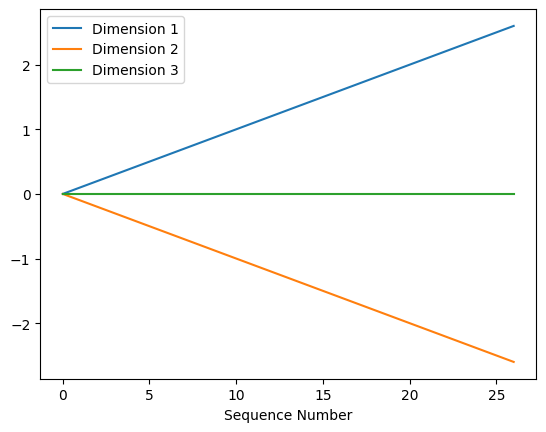

In [55]:
# Plot the first dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 0].numpy(), label="Dimension 1")

# Plot the second dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 1].numpy(), label="Dimension 2")

# Plot the third dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

# Label the x-axis as 'Sequence Number' to represent the position in the sequence
plt.xlabel("Sequence Number")

# Add a legend to the plot to identify which line corresponds to which dimension of positional encoding
plt.legend()

# Display the plot on screen
plt.show()


Observe that the words are closer together, but employing a linear function still presents the same drawbacks. This means that eventually, the embeddings will keep on increasing linearly.


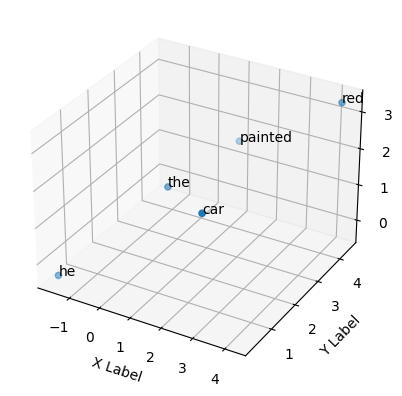

In [56]:
# After the positional encodings have been added, we need to detach the tensor from the computation graph
# and convert it to a NumPy array for visualization
# 'detach()' is necessary because 'embedded_x' requires gradients and we don't need them for plotting
# 'numpy()' converts the PyTorch tensor to a NumPy array
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the sample sentence to use as labels in the plot
tokens = tokenizer(my_tokens)

# Visualize the token embeddings with positional encodings
# The 'plot_embdings' function presumably takes the NumPy array of embeddings, token labels, and a vocabulary
# to plot the embeddings in a space where similar embeddings are closer together
plot_embdings(pos_embding_numpy, tokens, vocab)

When analyze positional encodings, it might appear that the words are closer together, indicating an improvement. However, it's crucial to recognize that the use of a linear function still comes with its own set of limitations. Despite the visual impression of words being in closer proximity, linear positional encodings have inherent issues. One significant problem is the potential for amplifying magnitudes as positions progress, which can adversely affect the model's ability to capture subtle positional nuances effectively.

To overcome these challenges, exploring alternative methods and functions for generating positional encodings is valuable. One promising approach involves leveraging periodic functions, such as sine and cosine functions. These functions possess a unique property called periodicity, meaning they repeat their values over regular intervals. This periodic nature prevents them from growing too rapidly as positions increase in the sequence.

By incorporating sine and cosine functions into positional encodings, introduces a more context-aware and adaptive mechanism. These functions allow us to capture the sequential information without the risk of magnitudes escalating uncontrollably. As a result, the model can better discern the relative positions of words within the sequence, leading to more accurate and meaningful representations.


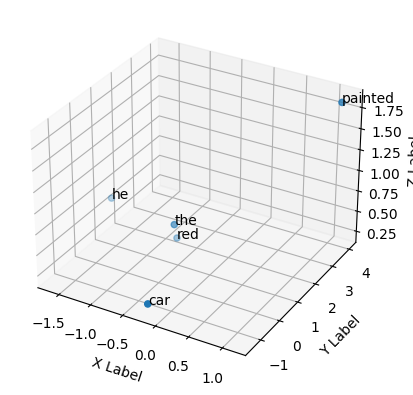

In [57]:
# Generate positional encodings using a sinusoidal function and concatenation
# The first dimension is encoded with a sine function
# The second and third dimensions are placeholders and are simply set to 1 (this is not typical in practice and likely serves as a simplified example)
pe = torch.cat((torch.sin(2 * 3.14 * position / 6),  # Sinusoidal encoding for dimension 1
                0 * position + 1,                     # Constant encoding (1) for dimension 2
                0 * position + 1), axis=1)            # Constant encoding (1) for dimension 3

# Add the sinusoidal positional encodings to the token embeddings
# This step enriches the embeddings with information about the position of each token in the sequence
pos_embding = embedded_x + pe[0:samples, :]

# Prepare the positional embeddings for visualization
# 'detach()' is used to stop tracking all operations on 'pos_embding'
# 'numpy()' converts the tensor to a NumPy array suitable for plotting
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the sample sentence to get the labels for the embedding plot
tokens = tokenizer(my_tokens)

# Visualize the embeddings using the plot function
# It is assumed the function will plot these embeddings in a way that illustrates the effects of adding positional encodings
plot_embdings(pos_embding_numpy, tokens, vocab)

The first dimension of **$pe$** follows a sine wave pattern, while the 2nd and 3rd dimensions have constant values. This is showcased in the graph below.


In [58]:
pe

tensor([[ 0.0000,  1.0000,  1.0000],
        [ 0.8658,  1.0000,  1.0000],
        [ 0.8666,  1.0000,  1.0000],
        [ 0.0016,  1.0000,  1.0000],
        [-0.8650,  1.0000,  1.0000],
        [-0.8673,  1.0000,  1.0000],
        [-0.0032,  1.0000,  1.0000],
        [ 0.8642,  1.0000,  1.0000],
        [ 0.8681,  1.0000,  1.0000],
        [ 0.0048,  1.0000,  1.0000],
        [-0.8634,  1.0000,  1.0000],
        [-0.8689,  1.0000,  1.0000],
        [-0.0064,  1.0000,  1.0000],
        [ 0.8626,  1.0000,  1.0000],
        [ 0.8697,  1.0000,  1.0000],
        [ 0.0080,  1.0000,  1.0000],
        [-0.8617,  1.0000,  1.0000],
        [-0.8705,  1.0000,  1.0000],
        [-0.0096,  1.0000,  1.0000],
        [ 0.8609,  1.0000,  1.0000],
        [ 0.8713,  1.0000,  1.0000],
        [ 0.0111,  1.0000,  1.0000],
        [-0.8601,  1.0000,  1.0000],
        [-0.8721,  1.0000,  1.0000],
        [-0.0127,  1.0000,  1.0000],
        [ 0.8593,  1.0000,  1.0000],
        [ 0.8728,  1.0000,  1.0000]])

In our exploration of word embeddings, we've noticed a fascinating pattern: words are generally positioned close enough in the embedding space to preserve their proximity, ensuring that they are contextually related while maintaining distinctiveness from one another. However, there's a significant exception that arises specifically with the word 'car.'

This peculiar behavior can be attributed to the nature of the sine wave used in positional encoding. The sine wave is inherently periodic, meaning it repeats its pattern at regular intervals. This periodicity is visually illustrated in the accompanying image, where you can observe the sinusoidal curve repeating itself. As a result, the positional encoding for the word 'car' at different locations within the sequence remains the same.

This periodic nature poses a challenge, especially for words like 'car,' which may appear multiple times in a sequence but carry different contextual meanings each time. Despite their varying contexts, the positional encoding for all occurrences of 'car' would be identical due to the repetitive pattern of the sine wave.


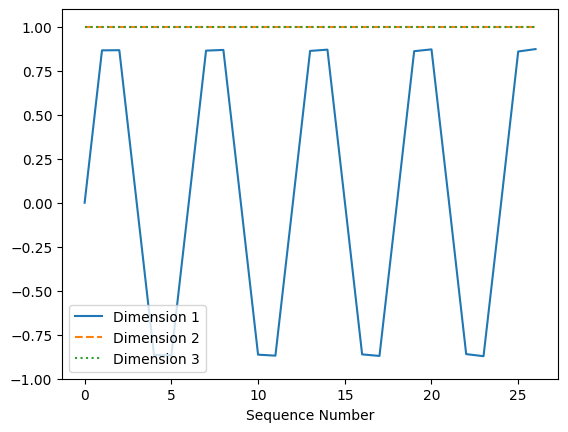

In [59]:
# Plot the positional encodings with different line styles and markers
plt.plot(pe[:, 0].numpy(), label="Dimension 1", linestyle='-')
plt.plot(pe[:, 1].numpy(), label="Dimension 2", linestyle='--')
plt.plot(pe[:, 2].numpy(), label="Dimension 3", linestyle=':')

# Adjust the y-axis scale for better visibility
plt.ylim([-1, 1.1])

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

By incorporating sine and cosine functions with varying frequencies, encode sequences of differing lengths. As demonstrated here, it becomes evident that these encodings position elements in such a way that they maintain proximity while still preserving their distinctiveness from one another


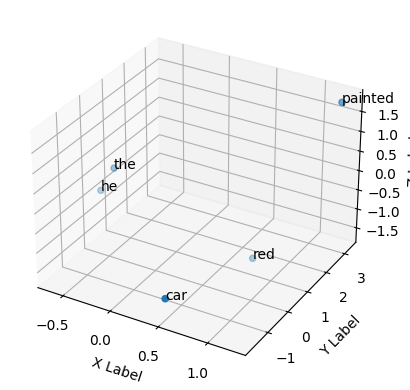

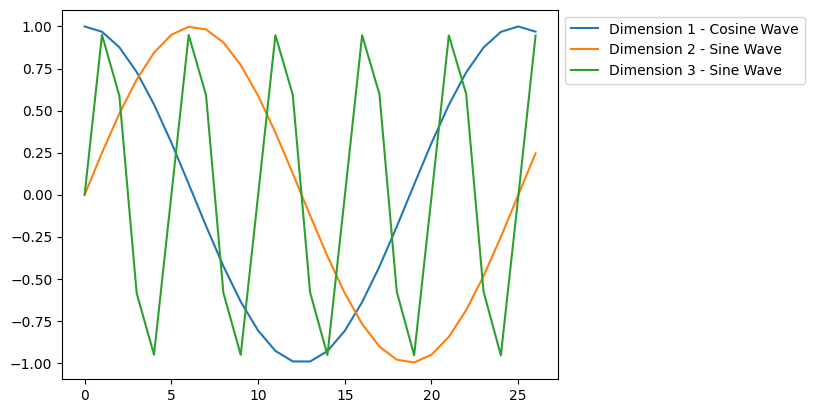

In [60]:
# Create positional encodings using sinusoidal functions
# Concatenate cosine and sine functions for different dimensions to form the encoding
pe = torch.cat((torch.cos(2 * 3.14 * position / 25),  # Cosine function for the first dimension
                torch.sin(2 * 3.14 * position / 25),  # Sine function for the second dimension
                torch.sin(2 * 3.14 * position / 5)), axis=1)  # Sine function with different frequency for the third dimension

# Add the generated positional encodings to the token embeddings
# This enriches the embeddings with positional information
pos_embding = embedded_x + pe[0:samples, :]

# Detach the embeddings from the computational graph and convert to NumPy for visualization
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the input text to be used as labels in the plot
tokens = tokenizer(my_tokens)

# Visualize the embeddings with positional encodings
plot_embdings(pos_embding_numpy, tokens, vocab)

# Additionally, plot each dimension of the positional encodings to visualize their patterns
plt.plot(pe[:, 0].numpy(), label="Dimension 1 - Cosine Wave")
plt.plot(pe[:, 1].numpy(), label="Dimension 2 - Sine Wave")
plt.plot(pe[:, 2].numpy(), label="Dimension 3 - Sine Wave")

# Add a legend in the upper left corner outside of the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

Overall, periodic functions provide a more expressive and adaptable means of encoding positional information in sequences, making them a preferred choice in modern sequence-to-sequence models like transformers. They offer improved capabilities for modeling both short-range and long-range dependencies, which are crucial for tasks in natural language processing and other domains.


Now that you comprehend positional encoding, embedding and self attention, let's put all layers together to create a transformer model that receives a sequence and transfrom it for further processes.


In [61]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding module injects information about the relative or absolute 
    position of tokens in a sequence. This helps the model understand the order of tokens.
    """
    def __init__(self, n_embd, vocab_size, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        # Create a buffer to store positional encodings; these are fixed and not updated during training
        pe = torch.zeros(vocab_size, n_embd)  # Initialize encoding matrix
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)  # Sequence of positions
        # Compute positional encodings using a combination of cosine and sine functions
        pe = torch.cat((
            torch.cos(2 * 3.14 * position / 25),  # Cosine encoding with a specific wavelength
            torch.sin(2 * 3.14 * position / 25),  # Sine encoding with the same wavelength
            torch.sin(2 * 3.14 * position / 5)    # Sine encoding with a shorter wavelength
        ), 1)
        self.register_buffer('pe', pe)  # Register 'pe' as a buffer so it’s not treated as a parameter

    def forward(self, x):
        """
        Add positional encoding to the input embeddings.
        
        Args:
            x: Tensor of shape (seq_len, batch_size, n_embd), representing embeddings of input tokens.
        
        Returns:
            Tensor of the same shape as input, with positional encoding added.
        """
        # Add the positional encoding to the input embeddings
        pos = x + self.pe[:x.size(0), :]
        return pos

class Head(nn.Module):
    """
    Self-attention head with positional encoding.
    This is a key component of transformer-based architectures.
    """
    def __init__(self, n_embd, vocab_size):
        super().__init__()
        # Embedding layer: Maps token indices to dense vectors of size n_embd
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # Positional encoding layer: Adds positional information to the embeddings
        self.pos_encoder = PositionalEncoding(n_embd, vocab_size)
        # Linear layers to compute queries, keys, and values from position-encoded embeddings
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def forward(self, x):
        """
        Forward pass of the self-attention head.
        
        Args:
            x: Input token indices of shape (seq_len, batch_size).
        
        Returns:
            out: Output tensor after applying the attention mechanism, of shape (seq_len, batch_size, n_embd).
        """
        # Convert token indices into embeddings
        embedded_x = self.embedding(x)
        # Add positional encoding to the embeddings
        p_encoded_x = self.pos_encoder(embedded_x)
        # Generate keys, queries, and values from position-encoded embeddings
        k = self.key(p_encoded_x)
        q = self.query(p_encoded_x)
        v = self.value(p_encoded_x)
        # Compute scaled dot-product attention weights
        w = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5  # Normalize by sqrt of key dimension
        w = F.softmax(w, dim=-1)  # Apply softmax to get attention probabilities
        # Compute the weighted sum of value vectors using the attention weights
        out = w @ v
        return out


In the code above, the `Head` class is an implementation of a self-attention mechanism. It first converts each input token into a dense vector using an embedding layer, and then adds positional information to the vectors using a positional encoding layer. This is done to give the model some information about the position of each token in the input sequence.

Next, the `Head` class creates three different linear projections (key, query, and value) of the positionally-encoded input data using the `nn.Linear` layers defined in the `__init__` method. These projections are created by multiplying the input data with three different weight matrices.

The attention scores (also known as attention weights) are then computed by taking the dot product of the query and key projections, and then scaling the result by the square root of the key dimension. This is done to stabilize the gradients during training. The softmax function is then applied to these scores to ensure they sum up to 1.

Finally, the output of the attention head is computed by taking a weighted sum of the value projection, where the weights are the attention scores. This output is a weighted sum of the input data, where the weights are determined by the relationships between all pairs of input data points.


In [62]:
# Instantiate the Head class with embedding dimension and vocabulary size as parameters
transformer = Head(n_embd, vocab_size)

# Pass the input data through the transformer model to obtain the output
# This process includes embedding the input, adding positional encodings, and applying self-attention
out = transformer(input_data)

# Print the shape of the output tensor
# The shape will provide insight into how the data has been transformed through the model
print("Output shape:", out.shape)

# Display the output tensor itself
# This output represents the transformed data after applying the embedding, positional encoding, and self-attention mechanisms
print("Output:", out)

Output shape: torch.Size([5, 3])
Output: tensor([[0.2440, 0.2375, 0.2930],
        [0.3904, 0.0916, 0.3816],
        [0.1794, 0.2450, 0.3874],
        [0.0538, 0.4241, 0.2249],
        [0.0521, 0.3947, 0.2893]], grad_fn=<MmBackward0>)


<a name="torchtr"></a>
# Transformers in PyTorch
In this section, you will learn how to create transfomer models using `nn.torch` library.

This code block creates an instance of the Transformer model from the nn (neural network) module in PyTorch. The nhead parameter specifies the number of heads in the multi-head attention mechanism, which is a crucial component of the Transformer architecture. In this case, it is set to 16.

The num_encoder_layers parameter determines the number of encoder layers in the Transformer model. Here, it is set to 12.


In [63]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)

These two lines create random tensors to represent the source and target sequences for the Transformer model.

`src` represents 10 source sequences, each with a length of 32 and a feature dimension of 512.
`tgt` represents 20 target sequences, each with a length of 32 and a feature dimension of 512.
In the context of sequence-to-sequence tasks, the source sequences are the input data (e.g., sentences in one language), and the target sequences are the desired output (e.g., the corresponding sentences in another language).


In [64]:
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))

Then, pass the source and target tensors through the Transformer model. The out variable will contain the output of the Transformer model, which should have the same shape as the tgt tensor ((20, 32, 512)). This output can be further processed or used for downstream tasks, such as calculating a loss function for training or generating text for inference.


In [66]:
out = transformer_model(src, tgt)
out.shape

torch.Size([20, 32, 512])

## MultiHead attention

`nn.MultiheadAttention` is a module in PyTorch that implements the multi-head self-attention mechanism, a key component of the Transformer architecture. This attention mechanism enables the model to focus on different parts of the input sequence simultaneously, capturing various contextual dependencies and improving the model's ability to process complex natural language patterns.

The `nn.MultiheadAttention` module has three main inputs: `query`, `key`, and `value` as illustrated below. 
<p style="text-align:center">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/MultiHeadAttention.png" width="300" alt="MultiHead"/>
</p>

The multi-head attention mechanism works by first splitting the `query`, `key`, and `value` inputs into multiple "heads," each with its own set of learnable weights. This process allows the model to learn different attention patterns in parallel. 

The outputs from all heads are concatenated and passed through a linear layer, known as the output projection, to combine the information learned by each head. This final output represents the contextually enriched sequence that can be used in subsequent layers of the Transformer model.


In [67]:

# Embedding dimension
embed_dim =4
# Number of attention heads
num_heads = 2
print("should be zero:",embed_dim %num_heads)
# Initialize MultiheadAttention
multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads,batch_first=False)

should be zero: 0


In [68]:
seq_length = 10 # Sequence length
batch_size = 5 # Batch size
query = torch.rand((seq_length, batch_size, embed_dim))
key = torch.rand((seq_length, batch_size, embed_dim))
value = torch.rand((seq_length, batch_size, embed_dim))
# Perform multi-head attention
attn_output, _= multihead_attn(query, key, value)
print("Attention Output Shape:", attn_output.shape)

Attention Output Shape: torch.Size([10, 5, 4])


## TransformerEncoderLayer and TransformerEncoder

The `TransformerEncoderLayer` and `TransformerEncoder` are essential components of the Transformer architecture in PyTorch. These components work together to create a multi-layer, attention-based neural network.

### TransformerEncoderLayer:
This is a single encoding layer in the Transformer architecture, consisting of two primary sub-layers as shown below: the Multi-head Self-Attention layer and the Feed-Forward Network (FFN). Each of these sub-layers is followed by a residual connection and layer normalization.
<p style="text-align:center">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/TrLayer.png" width="200" alt="TrLayer"/>
</p>


### TransformerEncoder:
The TransformerEncoder is a stack of multiple `TransformerEncoderLayer` instances. The encoder consists of N identical layers. N can be adjusted based on the desired complexity of the model.

The encoder takes an input sequence, applies positional encoding, and passes it through each of the TransformerEncoderLayers sequentially. This allows the model to learn rich, hierarchical representations of the input sequence, capturing both local and long-range dependencies.

TransformerEncoder accepts the following parameters:
- `src` (required): The sequence to the encoder.

- `mask` (Optional): The mask parameter is used to restrict the attention mechanism from considering certain positions in the input sequence. It is a binary tensor with the same shape as the input sequence. A value of 1 indicates that attention is allowed, while a value of 0 indicates that attention should be disregarded. This mask is particularly useful when working with triangular attention masks, where each position in the sequence can only attend to previous positions.

- `src_key_padding_mask` (Optional): The src_key_padding_mask parameter is used to specify which positions in the input sequence correspond to padding tokens. It is a binary tensor with shape (batch_size, sequence_length). A value of 1 indicates that the corresponding position contains a valid token, while a value of 0 indicates that the position contains a padding token. By providing this mask, the attention mechanism can ignore padding tokens and focus only on the meaningful parts of the input sequence. This parameter is particularly useful when dealing with variable-length sequences that have been padded to a fixed length.


In [69]:
# Embedding dimension
embed_dim = 4
# Number of attention h
num_heads = 2
# Checking if the embedding dimension is divisible by the number of heads, print("should be zero", embed_dim % num_h
# Number of encoder layers
num_layers = 6
# Initialize the encoder layer with specified embedding dimension and number of heads.
encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
# Build the transformer encoder by stacking the encoder layer 6 times.
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

Let's now test it with a random input:


In [70]:
# Define sequence length as 10 and batch size as 5 for the input data.
seq_length = 10 # Sequence length
batch_size = 5 # Batch size
# Generate random input tensor to simulate input embeddings for the transformer encoder.
x = torch.rand((seq_length, batch_size, embed_dim))
# Apply the transformer encoder to the input
encoded = transformer_encoder(x)
# Output the shape of the encoded tensor to verify the transformation.
print("Encoded Tensor Shape:", encoded.shape)

Encoded Tensor Shape: torch.Size([10, 5, 4])


## Exercise
In this exercise, you will create a multi-hear transformer and use it to encode a an input vector. To achieve this, you will leverage nn.TransformerEncoderLayer and nn.TransformerEncoder. 

>Please note that the `embedding size` should be divisible by the `number of attention heads`.

1. **Create a transformer encoder with the following parameters:**
   - `embedding size` = 240
   -  `number of layers` = 12
   -  `number of attention heads` = 12

2. **Create a random input tensor of length 20 and batch size of 1**

3. **Pass the input tensor to model and print the shape of its output**


In [71]:
embed_dim = 240
num_heads = 12
num_layers = 12
encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

seq_length = 20
batch_size = 1
x = torch.rand((seq_length, batch_size, embed_dim))
encoded = transformer_encoder(x)
print("Encoded Tensor Shape:", encoded.shape)

Encoded Tensor Shape: torch.Size([20, 1, 240])


<details>
    <summary>Click here for Solution</summary>

```python

embed_dim = 240
num_heads = 12
num_layers = 12
encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

seq_length = 20
batch_size = 1
x = torch.rand((seq_length, batch_size, embed_dim))
encoded = transformer_encoder(x)
print("Encoded Tensor Shape:", encoded.shape)
```

</details>


# Congratulations! You've achieved a thorough understanding of the inner workings of transformers.

## Authors

[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo) has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

[Fateme Akbari](https://www.linkedin.com/in/fatemeakbari/) is a Ph.D. candidate in Information Systems at McMaster University with demonstrated research experience in Machine Learning and NLP.

## Contributor

[Ashutosh Sagar](https://www.linkedin.com/in/ashutoshsagar/) is completing his MS in CS from Dalhousie University. He has previous experience working with Natural Language Processing and as a Data Scientist.

[Wojciech "Victor" Fulmyk](https://www.linkedin.com/in/wfulmyk)  Wojciech "Victor" Fulmyk is a Data Scientist at IBM, and a PhD Candidate in economics at the University of Calgary.

## References
[LLMs from dummies](https://github.com/pcingola/llms_from_dummies/blob/main/notebooks/LLMs_from_dummies_Part_1.ipynb) GitHub

© Copyright IBM Corporation. All rights reserved.
